# Computer Vision Problem

First 3 cells is just getting the data into the  right shape and importing the libraries needed

In [34]:
import cv2
import numpy as np
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import model_from_json
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from random_eraser import get_random_eraser
import pickle
from keras.layers import *
from keras.regularizers import l2
import matplotlib.pyplot as plt
with open('./train_image.pkl', 'rb') as f:
    train_data = pickle.load(f,encoding='utf-8')
with open('./train_label.pkl', 'rb') as f:
    labels = pickle.load(f,encoding='utf-8')

In [2]:
train_data = np.array(train_data).reshape(-1,28,28,1)
labels = np.array(labels)

Here I create the image data generator. The only augmentation I have used is cutout/random erasing and I have normalized(std=1) the centered(mean=0) the images. These are augmentations that after trial and error worked the best. Cutout greatly improved the accuracy and the normalization and centering greatly increased the speed of training. 

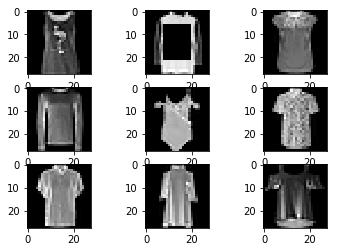

In [3]:
datagen = ImageDataGenerator(featurewise_center=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1),featurewise_std_normalization=True)#,vertical_flip=True,width_shift_range=.2,height_shift_range=.2,fill_mode='nearest')
img_rows = 28
img_cols = 28
# fit parameters from data
datagen.fit(train_data)

# Configure batch size and retrieve one batch of images
for X_batch, y_batch in datagen.flow(train_data, labels, batch_size=9):
    # Show 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(img_rows, img_cols),cmap='gray')
    # show the plot
    plt.show()
    break

Dividing the data into train and test sets

In [4]:
batch_size = 32
labels[labels==2]=1
labels[labels==3]=2
labels[labels==6]=3
train_y = np.zeros((labels.shape[0], 4))
train_y[np.arange(labels.shape[0]),labels] = 1
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
train_data, train_y = shuffle(train_data, train_y, random_state=0)
train_data, test_data, train_y, test_y = train_test_split(train_data, train_y, test_size=0.10, random_state=42)

A simple model to start with, Just a straightforward neural network.

In [9]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28, 1)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [10]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 100,996
Trainable params: 100,996
Non-trainable params: 0
_________________________________________________________________


The training gives great training accuracy but really bad test accuracy. So let's move onto convolutional neural networks.

In [12]:
history = model.fit_generator(datagen.flow(train_data, train_y, batch_size=batch_size),
                        steps_per_epoch=train_data.shape[0] // batch_size,
                        epochs=100,shuffle = True,validation_data=(test_data, test_y))

Epoch 1/100
225/225 [==============================] - 1s 2ms/step - loss: 0.6323 - acc: 0.7501 - val_loss: 4.8744 - val_acc: 0.6800
Epoch 2/100
225/225 [==============================] - 1s 3ms/step - loss: 0.5063 - acc: 0.8000 - val_loss: 3.7643 - val_acc: 0.7450
Epoch 3/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4659 - acc: 0.8149 - val_loss: 4.1858 - val_acc: 0.7275
Epoch 4/100
225/225 [==============================] - 1s 3ms/step - loss: 0.4354 - acc: 0.8261 - val_loss: 5.1050 - val_acc: 0.6663
Epoch 5/100
225/225 [==============================] - 1s 2ms/step - loss: 0.4144 - acc: 0.8386 - val_loss: 2.9877 - val_acc: 0.8100
Epoch 6/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3997 - acc: 0.8444 - val_loss: 3.4666 - val_acc: 0.7750
Epoch 7/100
225/225 [==============================] - 1s 2ms/step - loss: 0.3914 - acc: 0.8438 - val_loss: 4.4283 - val_acc: 0.7125
Epoch 8/100
225/225 [==============================] - 0s 2ms/step - 

Here is a simple convolutional network with some fully connected layers and dropout for regularization

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 64
num_classes = 7
epochs = 10
input_shape = (28,28,1)
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.85))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.85))
model.add(Dense(128,activation='relu'))
model.add(Dense(4, activation='softmax'))
print(model.summary())
datagen.fit(train_data)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_y, batch_size=batch_size),
                        steps_per_epoch=train_data.shape[0] // batch_size,
                        epochs=200,shuffle = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 256)       37120     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 12, 12, 256)       0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 36864)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               9437440   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
__________

125/125 [==============================] - 3s 21ms/step - loss: 0.3949 - acc: 0.8558
Epoch 70/200
125/125 [==============================] - 3s 22ms/step - loss: 0.3881 - acc: 0.8595
Epoch 71/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3919 - acc: 0.8554
Epoch 72/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3950 - acc: 0.8538
Epoch 73/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3862 - acc: 0.8579
Epoch 74/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3927 - acc: 0.8554
Epoch 75/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3902 - acc: 0.8566
Epoch 76/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3894 - acc: 0.8586
Epoch 77/200
125/125 [==============================] - 3s 22ms/step - loss: 0.3898 - acc: 0.8570
Epoch 78/200
125/125 [==============================] - 3s 21ms/step - loss: 0.3749 - acc: 0.8602
Epoch 79/200
125/125 [===========

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(lr = 1e-3),
                metrics=['accuracy'])
history2 = model.fit_generator(datagen.flow(train_data, train_y, batch_size=batch_size),
                        steps_per_epoch=train_data.shape[0] // batch_size,
                        epochs=200,shuffle = True)

Epoch 1/200
125/125 [==============================] - 4s 30ms/step - loss: 0.2833 - acc: 0.8964
Epoch 2/200
125/125 [==============================] - 3s 20ms/step - loss: 0.2874 - acc: 0.8909
Epoch 3/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2831 - acc: 0.8939
Epoch 4/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2956 - acc: 0.8948
Epoch 5/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2868 - acc: 0.8924
Epoch 6/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2809 - acc: 0.8984
Epoch 7/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2812 - acc: 0.8989
Epoch 8/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2800 - acc: 0.8952
Epoch 9/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2827 - acc: 0.8984
Epoch 10/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2814 - acc: 0.8967
Epoch 11/200
125/125 [=======

125/125 [==============================] - 3s 22ms/step - loss: 0.2666 - acc: 0.9036
Epoch 168/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2758 - acc: 0.9009
Epoch 169/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2705 - acc: 0.9044
Epoch 170/200
125/125 [==============================] - 3s 20ms/step - loss: 0.2795 - acc: 0.9044
Epoch 171/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2588 - acc: 0.9086
Epoch 172/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2628 - acc: 0.9035
Epoch 173/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2844 - acc: 0.9020
Epoch 174/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2803 - acc: 0.9001
Epoch 175/200
100/125 [=======================>......] - ETA: 0s - loss: 0.2720 - acc: 0.8986

This model was trained for around 400 epochs. Let's load it and evaluate it. This model was trained on the entire data so the accuracy will be very good. But again it can't be used as we will se later as it doesn't generalize well.

In [19]:
# model_json = model.to_json()
# with open("model_2.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model_2.h5")
# print("Saved model to disk")
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2.h5")
print("Loaded model from disk")

Loaded model from disk


In [21]:
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
score = loaded_model.evaluate(test_data, test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 93.88%


Now I have started just incrementing one layer at a time and add more regularization via dropout

In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 64
num_classes = 7
epochs = 10
input_shape = (28,28,1)
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.85))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.85))
model.add(Dense(128,activation='relu'))
model.add(Dense(4, activation='softmax'))
print(model.summary())
datagen.fit(train_data)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 256)       37120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 10, 10, 256)       590080    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6553856   
__________

In [8]:
history = model.fit_generator(datagen.flow(train_data, train_y, batch_size=batch_size,shuffle = True),
                        steps_per_epoch=train_data.shape[0] // batch_size,
                        epochs=200,shuffle = True)

Epoch 1/200
125/125 [==============================] - 4s 31ms/step - loss: 11.8139 - acc: 0.2600
Epoch 2/200
125/125 [==============================] - 3s 22ms/step - loss: 11.9170 - acc: 0.2578
Epoch 3/200
125/125 [==============================] - 3s 22ms/step - loss: 11.8416 - acc: 0.2625
Epoch 4/200
125/125 [==============================] - 3s 22ms/step - loss: 11.7001 - acc: 0.2714
Epoch 5/200
125/125 [==============================] - 3s 22ms/step - loss: 11.6148 - acc: 0.2780
Epoch 6/200
125/125 [==============================] - 3s 22ms/step - loss: 11.6561 - acc: 0.2755
Epoch 7/200
125/125 [==============================] - 3s 22ms/step - loss: 11.5322 - acc: 0.2819
Epoch 8/200
125/125 [==============================] - 3s 22ms/step - loss: 11.5625 - acc: 0.2810
Epoch 9/200
125/125 [==============================] - 3s 22ms/step - loss: 11.3224 - acc: 0.2965
Epoch 10/200
125/125 [==============================] - 3s 22ms/step - loss: 11.2363 - acc: 0.3017
Epoch 11/200
125/12

125/125 [==============================] - 3s 22ms/step - loss: 0.2698 - acc: 0.9014
Epoch 168/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2776 - acc: 0.9032
Epoch 169/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2797 - acc: 0.9062
Epoch 170/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2641 - acc: 0.9091
Epoch 171/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2704 - acc: 0.9077
Epoch 172/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2707 - acc: 0.9034
Epoch 173/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2797 - acc: 0.8981
Epoch 174/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2709 - acc: 0.9030
Epoch 175/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2730 - acc: 0.9069
Epoch 176/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2732 - acc: 0.9050
Epoch 177/200
125/125 [=

In [9]:
history = model.fit_generator(datagen.flow(train_data, train_y, batch_size=batch_size,shuffle = True),
                        steps_per_epoch=train_data.shape[0] // batch_size,
                        epochs=200,shuffle = True)

Epoch 1/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2586 - acc: 0.9129
Epoch 2/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2604 - acc: 0.9128
Epoch 3/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2696 - acc: 0.9085
Epoch 4/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2511 - acc: 0.9149
Epoch 5/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2479 - acc: 0.9158
Epoch 6/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2566 - acc: 0.9130
Epoch 7/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2605 - acc: 0.9114
Epoch 8/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2449 - acc: 0.9155
Epoch 9/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2526 - acc: 0.9133
Epoch 10/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2460 - acc: 0.9190
Epoch 11/200
125/125 [=======

125/125 [==============================] - 3s 21ms/step - loss: 0.2125 - acc: 0.9286
Epoch 168/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2033 - acc: 0.9339
Epoch 169/200
125/125 [==============================] - 3s 22ms/step - loss: 0.1942 - acc: 0.9391
Epoch 170/200
125/125 [==============================] - 3s 21ms/step - loss: 0.1972 - acc: 0.9360
Epoch 171/200
125/125 [==============================] - 3s 21ms/step - loss: 0.1958 - acc: 0.9371
Epoch 172/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2047 - acc: 0.9346
Epoch 173/200
125/125 [==============================] - 3s 22ms/step - loss: 0.2146 - acc: 0.9325
Epoch 174/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2028 - acc: 0.9351
Epoch 175/200
125/125 [==============================] - 3s 21ms/step - loss: 0.2068 - acc: 0.9343
Epoch 176/200
125/125 [==============================] - 3s 21ms/step - loss: 0.1975 - acc: 0.9329
Epoch 177/200
125/125 [=

In [67]:
json_file = open('model_3.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_3.h5")
print(loaded_model.summary())
print("Loaded model from disk")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 256)       37120     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 256)       590080    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 10, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               6553856   
__________

This model was also trained on the entire data but a considerable accuracy gain is observed

In [25]:
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
score = loaded_model.evaluate(test_data, test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

acc: 98.62%


## My best Model

### After countless experimentation, this is a model that got 87% test accuracy and this is the one that I will be using to build the CSV file. The architecture is just a straightforward series of convolutions and Dropout and Dense layers. The validation, training loss and accuracy plot is also available. 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 64
num_classes = 7
epochs = 10
input_shape = (28,28,1)
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Dropout(0.85))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.85))
model.add(Dense(128,activation='relu'))
model.add(Dense(4, activation='softmax'))
print(model.summary())
datagen.fit(train_data)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 256)       37120     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 10, 10, 256)       590080    
_________________________________________________________________
dropout_7 (Dropout)          (None, 10, 10, 256)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 25600)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               13107712  
__________

In [10]:
history3 = model.fit_generator(datagen.flow(train_data, train_y, batch_size=batch_size,shuffle = True),
                        steps_per_epoch=train_data.shape[0] // batch_size,
                        epochs=400,shuffle = True, validation_data=(test_data, test_y))

Epoch 1/400
112/112 [==============================] - 5s 41ms/step - loss: 11.9211 - acc: 0.2543 - val_loss: 12.0212 - val_acc: 0.2537
Epoch 2/400
112/112 [==============================] - 5s 49ms/step - loss: 11.7959 - acc: 0.2654 - val_loss: 11.9274 - val_acc: 0.2600
Epoch 3/400
112/112 [==============================] - 8s 74ms/step - loss: 11.6935 - acc: 0.2716 - val_loss: 10.0067 - val_acc: 0.3738
Epoch 4/400
112/112 [==============================] - 7s 63ms/step - loss: 10.5659 - acc: 0.3391 - val_loss: 9.0253 - val_acc: 0.4363
Epoch 5/400
112/112 [==============================] - 5s 47ms/step - loss: 4.9805 - acc: 0.4748 - val_loss: 0.8077 - val_acc: 0.6900
Epoch 6/400
112/112 [==============================] - 8s 68ms/step - loss: 0.8305 - acc: 0.6544 - val_loss: 0.5903 - val_acc: 0.7850
Epoch 7/400
112/112 [==============================] - 8s 71ms/step - loss: 0.7408 - acc: 0.7183 - val_loss: 0.5652 - val_acc: 0.7775
Epoch 8/400
112/112 [==============================] - 

Epoch 62/400
112/112 [==============================] - 3s 27ms/step - loss: 0.2798 - acc: 0.9037 - val_loss: 0.3995 - val_acc: 0.8712
Epoch 63/400
112/112 [==============================] - 3s 27ms/step - loss: 0.2734 - acc: 0.9000 - val_loss: 0.3793 - val_acc: 0.8662
Epoch 64/400
112/112 [==============================] - 3s 27ms/step - loss: 0.2787 - acc: 0.9004 - val_loss: 0.3962 - val_acc: 0.8750
Epoch 65/400
112/112 [==============================] - 3s 27ms/step - loss: 0.2583 - acc: 0.9082 - val_loss: 0.3847 - val_acc: 0.8775
Epoch 66/400
112/112 [==============================] - 3s 28ms/step - loss: 0.2513 - acc: 0.9104 - val_loss: 0.4562 - val_acc: 0.8700
Epoch 67/400
112/112 [==============================] - 3s 28ms/step - loss: 0.2584 - acc: 0.9068 - val_loss: 0.4132 - val_acc: 0.8650
Epoch 68/400
112/112 [==============================] - 3s 28ms/step - loss: 0.2645 - acc: 0.9060 - val_loss: 0.3884 - val_acc: 0.8750
Epoch 69/400
112/112 [==============================] -

112/112 [==============================] - 3s 27ms/step - loss: 0.1412 - acc: 0.9608 - val_loss: 0.6787 - val_acc: 0.8800
Epoch 183/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1466 - acc: 0.9586 - val_loss: 0.6116 - val_acc: 0.8762
Epoch 184/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1330 - acc: 0.9612 - val_loss: 0.6451 - val_acc: 0.8750
Epoch 185/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1422 - acc: 0.9565 - val_loss: 0.5421 - val_acc: 0.8800
Epoch 186/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1499 - acc: 0.9573 - val_loss: 0.5576 - val_acc: 0.8775
Epoch 187/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1422 - acc: 0.9621 - val_loss: 0.7197 - val_acc: 0.8838
Epoch 188/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1400 - acc: 0.9577 - val_loss: 0.5735 - val_acc: 0.8700
Epoch 189/400
112/112 [==============================] - 3s 27

112/112 [==============================] - 3s 28ms/step - loss: 0.1166 - acc: 0.9692 - val_loss: 0.5719 - val_acc: 0.8712
Epoch 303/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1037 - acc: 0.9717 - val_loss: 0.7199 - val_acc: 0.8800
Epoch 304/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1233 - acc: 0.9681 - val_loss: 0.6658 - val_acc: 0.8775
Epoch 305/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1257 - acc: 0.9662 - val_loss: 0.6221 - val_acc: 0.8762
Epoch 306/400
112/112 [==============================] - 3s 27ms/step - loss: 0.0996 - acc: 0.9761 - val_loss: 0.6951 - val_acc: 0.8850
Epoch 307/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1152 - acc: 0.9679 - val_loss: 0.7964 - val_acc: 0.8812
Epoch 308/400
112/112 [==============================] - 3s 27ms/step - loss: 0.1068 - acc: 0.9706 - val_loss: 0.6407 - val_acc: 0.8825
Epoch 309/400
112/112 [==============================] - 3s 27

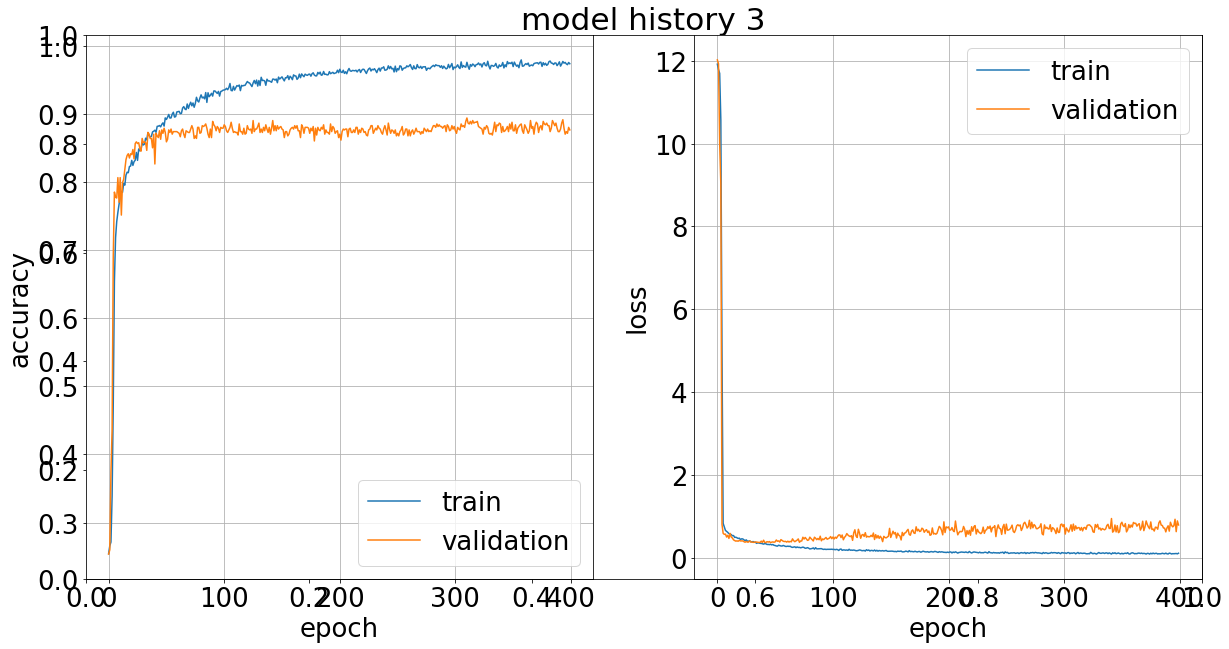

In [12]:
import pickle
#print(history.history)
from visualization import *
historyFilePath = 'model-train-history3.png'
trainingHistoryPlot("model history 3", historyFilePath, history3.history)

pickleFilePath = 'model-history3-dict.pickle'
with open(pickleFilePath, 'wb') as handle:
    pickle.dump(history3.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
model_json = model.to_json()
with open("model_2_final.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model_2_final.h5")
print("Saved model to disk")

Saved model to disk


Evaluation of the best model

In [53]:
json_file = open('model_2_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model_2_final.h5")
print("Loaded model from disk")
loaded_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
                metrics=['accuracy'])
score = loaded_model.evaluate(test_data, test_y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
acc: 87.62%


### SE-Resnet

I also attempted building a SE-Resnet. But for some reason it dosen't converge on this dataset as well as I expected. It just performs on-par with my best model and So i don't believe the computational weight is justified but still, I felt like I should showcase it. I have trained it in a different notebook that I will put in repository but I'm adding the code here just in case. The training and evaluation results can be found in the other notebook.

In [29]:
def squeeze_excite_block(input, ratio=16):
    filter_kernels = input._keras_shape[-1]
    z_shape = (1, 1, filter_kernels)
    z = GlobalAveragePooling2D()(input)
    z = Reshape(z_shape)(z)
    s = Dense(filter_kernels//ratio, activation='relu', use_bias=False)(z)
    s = Dense(filter_kernels, activation='sigmoid', use_bias=False)(s)
    x = multiply([input, s])
    return x

In [30]:
def se_resnet_block_bottleneck(input,channels,_strides=(1, 1)):
    chan_axis=-1
    if(input._keras_shape[-1]!=channels or _strides!=(1,1)):
        input = Conv2D(channels, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(input)
    
    x = Conv2D(channels, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(input)
    x = BatchNormalization(axis=chan_axis)(x)
    x = Activation('relu')(x)
    
    
    x = Conv2D(channels, (3, 3), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(x)
    x = BatchNormalization(axis=chan_axis)(x)
    x = Activation('relu')(x)
    
    
    x = Conv2D(channels, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(x)
    x = BatchNormalization(axis=chan_axis)(x)
    x = Activation('relu')(x)
    
    
    x = squeeze_excite_block(x)
    out = add([x, input])
    return out

In [31]:
def se_resnet(input,filters = [64,128,256,256,512],depth = [6,8,12,8,6],num_classes=4, weight_decay=1e-4):
# def se_resnet(input,filters = [64,128,256],depth = [6,8,6],num_classes=4, weight_decay=1e-4):
    chan_axis=-1
    x = Conv2D(filters[0], (3, 3), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = MaxPooling2D(pool_size=(2,2))(x)
    for i in range(len(filters)):
        x = se_resnet_block_bottleneck(x,filters[i],(2,2))
        for j in range(depth[i]-1):
            x = se_resnet_block_bottleneck(x,filters[i],(1,1))
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.85)(x)
    x = Dense(num_classes, activation='softmax', use_bias=False)(x)
    return x

In [32]:
def create_model(input_shape = (28, 28, 1),filters = [64,128,256,256,512],depth = [6,8,12,8,6],num_classes=4, weight_decay=1e-4):
#def create_model(input_shape = (28, 28, 1),filters = [64,128,256],depth = [6,8,6],num_classes=4, weight_decay=1e-4):
    input = Input(shape = input_shape)
    x = se_resnet(input,filters,depth,num_classes)
    model = Model(input, x)
    print(model.summary())
    return model

In [35]:
model = create_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   576         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     4096        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

In [87]:
with open('./test_image.pkl', 'rb') as f:
    csv_data = pickle.load(f,encoding='utf-8')
csv_data = np.array(csv_data).reshape(-1,28,28,1)

Here are sample results on some of the test images

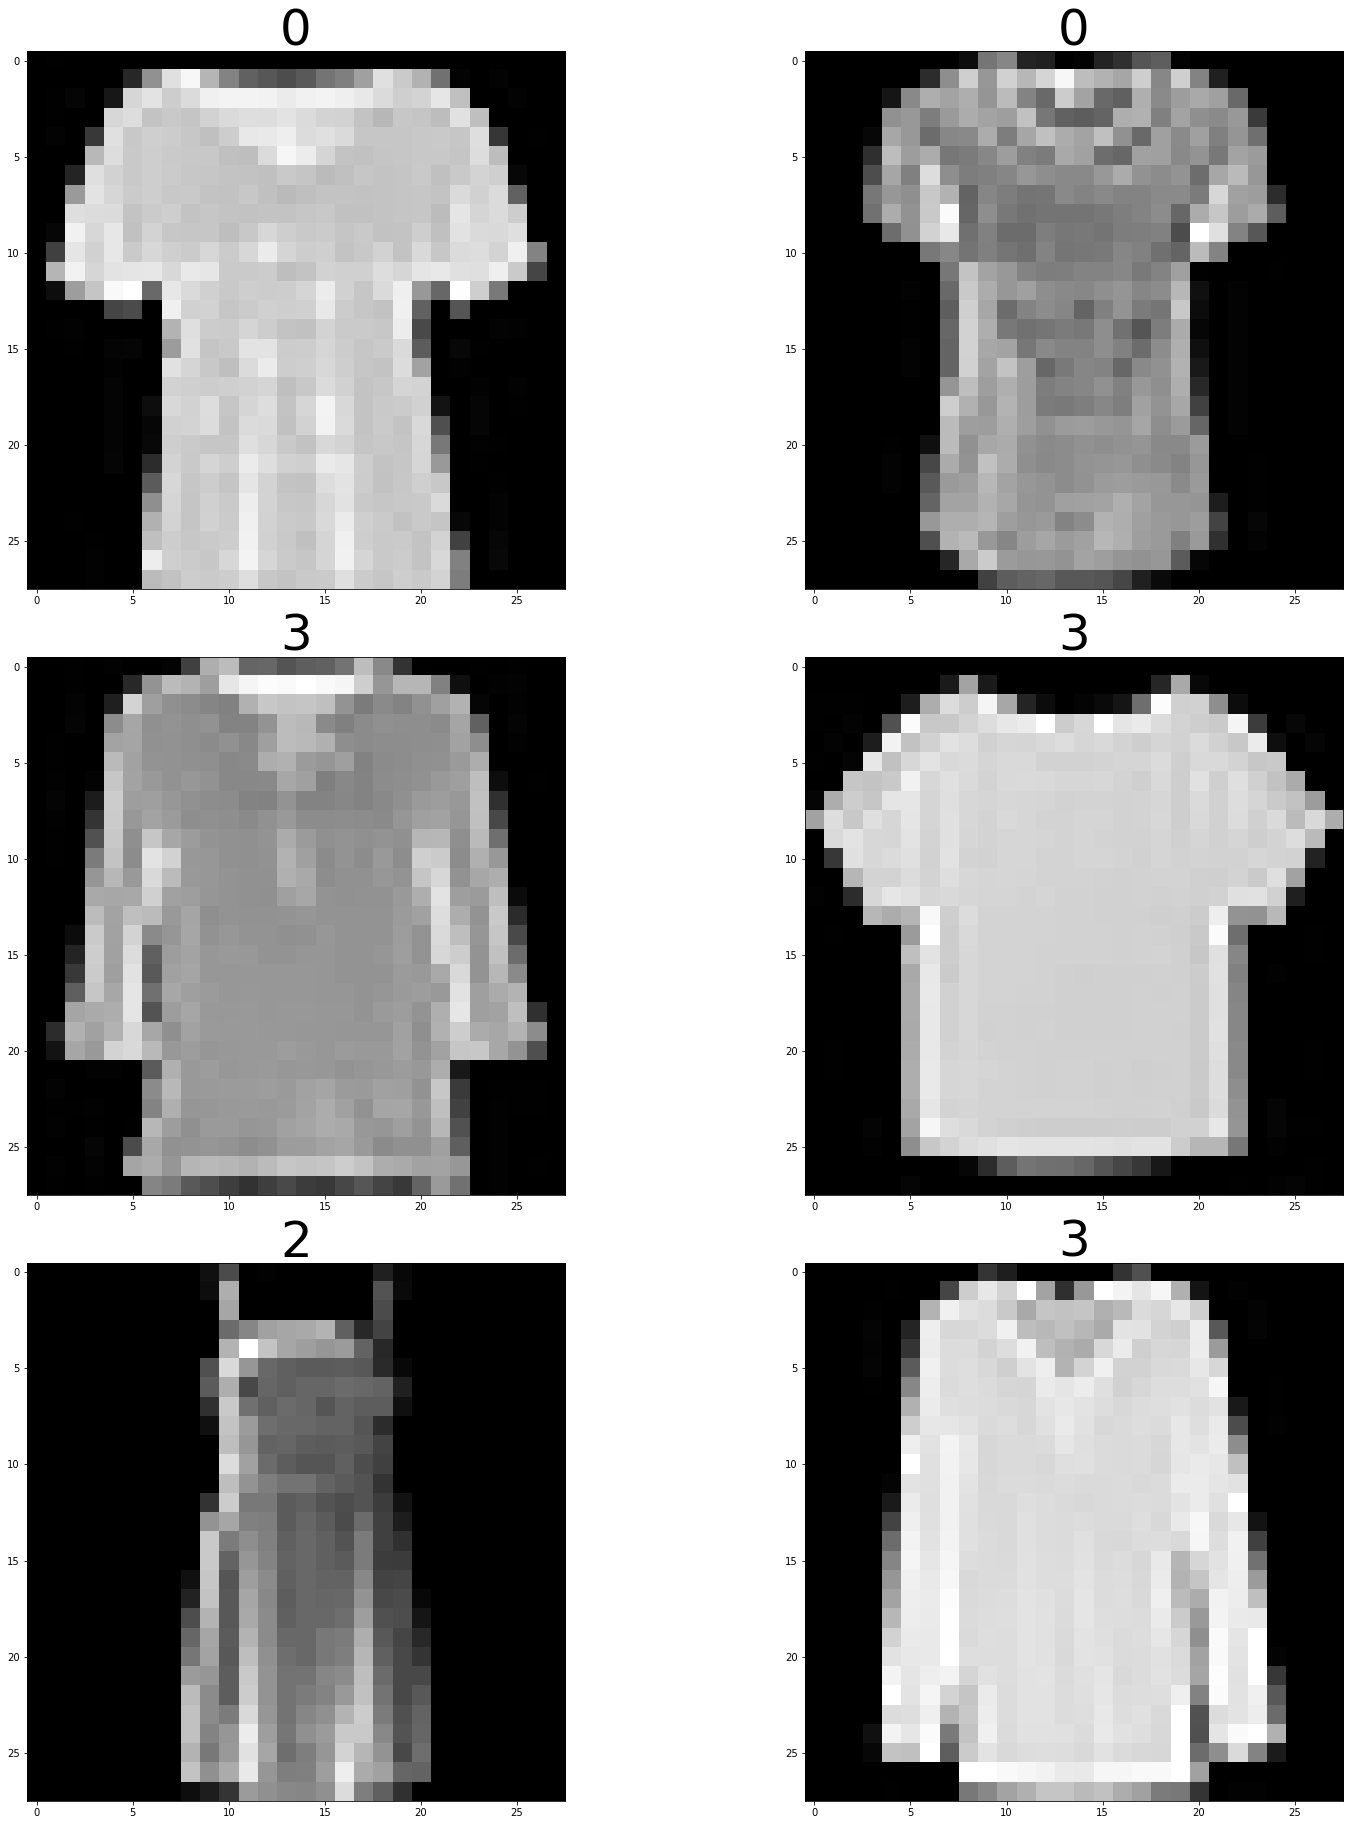

In [72]:
import random
f, (ax1r, ax2r,ax3r) = plt.subplots(3, 2, figsize=(24, 27))
ax1,ax2 = ax1r
ax3,ax4 = ax2r
ax5,ax6 = ax3r
f.tight_layout()
index = random.randint(0, len(csv_data))
ax1.imshow(csv_data[450][:,:,0],cmap = 'gray')
ax1.set_title(str(np.argmax(model.predict(csv_data[450].reshape(-1,28,28,1)))), fontsize=50)
index = random.randint(0, len(csv_data))
ax2.imshow(csv_data[index][:,:,0],cmap='gray')
ax2.set_title(str(np.argmax(model.predict(csv_data[index].reshape(-1,28,28,1)))), fontsize=50)
index = random.randint(0, len(csv_data))
ax3.imshow(csv_data[index][:,:,0], cmap='gray')
ax3.set_title(str(np.argmax(model.predict(csv_data[index].reshape(-1,28,28,1)))), fontsize=50)
index = random.randint(0, len(csv_data))
ax4.imshow(csv_data[index][:,:,0], cmap='gray')
ax4.set_title(str(np.argmax(model.predict(csv_data[index].reshape(-1,28,28,1)))), fontsize=50)
index = random.randint(0, len(csv_data))
ax5.imshow(csv_data[index][:,:,0], cmap='gray')
ax5.set_title(str(np.argmax(model.predict(csv_data[index].reshape(-1,28,28,1)))), fontsize=50)
index = random.randint(0, len(csv_data))
ax6.imshow(csv_data[index][:,:,0], cmap='gray')
ax6.set_title(str(np.argmax(model.predict(csv_data[index].reshape(-1,28,28,1)))), fontsize=50)
f.tight_layout()
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)